# Spectrum xAI

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import sys

from src.data.dataset import DAGMDataset
from src.models.models import DenseNetClassifier
from src.models.train_model import train_model
from src.models.evaluation import evaluate_model
from src.task.gradcam import show_gradcam
from src.task.gradient_shap import show_gradient_shap
from src.task.scorecam import show_scorecam
from src.task.integrated_gradient import show_integrated_gradient

import sys 
sys.dont_write_bytecode = True

## Data Loading

In [3]:
CLASS = 1
IMAGE_PATH = f"data/dataset/Class{CLASS}/"

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = DAGMDataset(root_dir=IMAGE_PATH, split="Train", transform=transform)
test_dataset = DAGMDataset(root_dir=IMAGE_PATH, split="Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 575
Test dataset size: 575


## Model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetClassifier(pretrained=True, device=device)

criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

### Training

In [6]:
# train_accuracies, train_losses = train_model(model, train_loader, num_epochs, criterion, optimizer, device)
# model.save_model(f"data/models/densenet121_class{CLASS}.pt")

### Evaluation

In [7]:
model.load_model(f"data/models/model_densenet121_class{CLASS}.pth")
test_accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 100.00%


## Explanation

In [8]:
index = 1
image, label = test_dataset[index][0].unsqueeze(0), test_dataset[index][1]
print(f'True Label: {label}')

True Label: 1


True Label: 1


c:\Users\ismoi\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


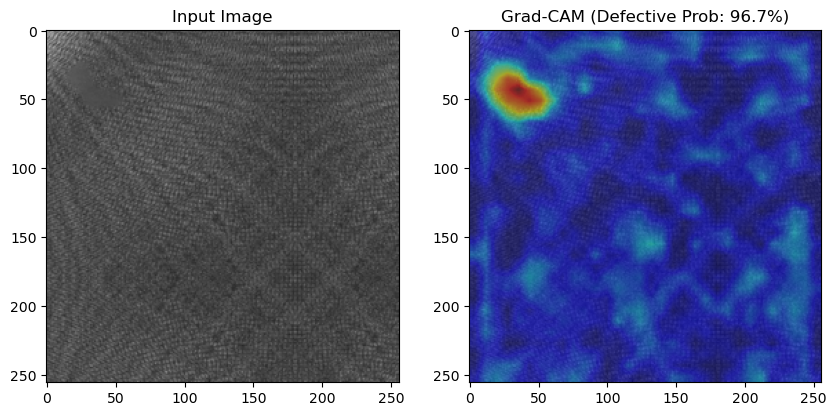

In [ ]:
show_gradcam(model.model, image, 6, device)

In [ ]:
show_gradient_shap(model.model, image, device, num_samples=100)

In [ ]:
show_scorecam(model.model, image, -2, device)

In [ ]:
show_integrated_gradient(model.model, image, device, n_steps=70)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
